In [1]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torchvision.io import read_image

import albumentations as A # Library for augmentations

In [2]:
print(torch.__version__)

1.11.0


In [3]:
torch.cuda.is_available()

True

# change the number of keypoints in cocotools

C:\Users\CallumMacpherson\anaconda3\envs\park\Lib\site-packages\pycocotools

# 1. Imports

In [4]:
# https://github.com/pytorch/vision/tree/main/references/detection
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

# 2. Read in the data

In [5]:
import pandas as pd
gt_label_df = pd.read_csv('BBox_keypoint_mich.csv', index_col=0)
gt_label_df['filename']=gt_label_df['patient ID'] + "_" + gt_label_df['img_no']
gt_label_df.head()

,patient ID,img_no,finger x,finger y,thumb x,thumb y,wristlow x,wristlow y,wristhigh x,wristhigh y,knuckle1 x,knuckle1 y,knuckle2 x,knuckle2 y,class,x1,y1,x2,y2,filename
0,OC01_R_10s_lowfps,img000.png,527.435088,643.753157,568.125216,694.943964,826.704422,924.646304,909.397265,822.26469,795.202387,652.94125,648.192889,637.190233,0,121.663802,113.942607,1241.663802,1233.942607,OC01_R_10s_lowfps_img000.png


In [6]:
gt_label_df.columns

Index(['patient ID', 'img_no', 'finger x', 'finger y', 'thumb x', 'thumb y',
       'wristlow x', 'wristlow y', 'wristhigh x', 'wristhigh y', 'knuckle1 x',
       'knuckle1 y', 'knuckle2 x', 'knuckle2 y', 'class', 'x1', 'y1', 'x2',
       'y2', 'filename'],
      dtype='object')

## Need to ensure that there are no NaNs in the labels

In [7]:
gt_label_df = gt_label_df[~gt_label_df.isna().any(axis=1)]
gt_label_df

,patient ID,img_no,finger x,finger y,thumb x,thumb y,wristlow x,wristlow y,wristhigh x,wristhigh y,knuckle1 x,knuckle1 y,knuckle2 x,knuckle2 y,class,x1,y1,x2,y2,filename
0,OC01_R_10s_lowfps,img000.png,527.435088,643.753157,568.125216,694.943964,826.704422,924.646304,909.397265,822.26469,795.202387,652.94125,648.192889,637.190233,0,121.663802,113.942607,1241.663802,1233.942607,OC01_R_10s_lowfps_img000.png


## Need to get rid of missing images from label df

In [8]:
true_files = os.listdir("../data")

In [9]:
gt_label_df['filename']

0    OC01_R_10s_lowfps_img000.png
Name: filename, dtype: object

In [10]:
gt_label_df = gt_label_df[gt_label_df['filename'].isin(true_files)]
gt_label_df.head()

,patient ID,img_no,finger x,finger y,thumb x,thumb y,wristlow x,wristlow y,wristhigh x,wristhigh y,knuckle1 x,knuckle1 y,knuckle2 x,knuckle2 y,class,x1,y1,x2,y2,filename
0,OC01_R_10s_lowfps,img000.png,527.435088,643.753157,568.125216,694.943964,826.704422,924.646304,909.397265,822.26469,795.202387,652.94125,648.192889,637.190233,0,121.663802,113.942607,1241.663802,1233.942607,OC01_R_10s_lowfps_img000.png


In [11]:
table_filenames = gt_label_df['filename'].tolist()

In [12]:
len(true_files)

1

In [13]:
bad_filenames = (list(set(table_filenames) - set(true_files)))
len(bad_filenames)

0

In [14]:
gt_label_df = gt_label_df[~gt_label_df['filename'].isin(bad_filenames)]


## Getting rid of the bounding box dims that extend the image boundaries

In [15]:
gt_label_df['x1'].min(), gt_label_df['x2'].max(), gt_label_df['y1'].min(), gt_label_df['y2'].max()

(121.66380180401188, 1241.663801804012, 113.94260719352587, 1233.942607193526)

In [16]:
#making it so that all labels are 10px within image boundaries
gt_label_df.loc[gt_label_df['x1'] <= 10, 'x1'] = 10
gt_label_df.loc[gt_label_df['x2'] >= 1910, 'x2'] = 1910
gt_label_df.loc[gt_label_df['y1'] <= 10, 'y1'] = 10
gt_label_df.loc[gt_label_df['y2'] >= 1070, 'y2'] = 1070


In [17]:
gt_label_df['x1'].min(), gt_label_df['x2'].max(), gt_label_df['y1'].min(), gt_label_df['y2'].max()

(121.66380180401188, 1241.663801804012, 113.94260719352587, 1070.0)

In [18]:
gt_label_df.min()

patient ID                OC01_R_10s_lowfps
img_no                           img000.png
finger x                         527.435088
finger y                         643.753157
thumb x                          568.125216
thumb y                          694.943964
wristlow x                       826.704422
wristlow y                       924.646304
wristhigh x                      909.397265
wristhigh y                       822.26469
knuckle1 x                       795.202387
knuckle1 y                        652.94125
knuckle2 x                       648.192889
knuckle2 y                       637.190233
class                                     0
x1                               121.663802
y1                               113.942607
x2                              1241.663802
y2                                   1070.0
filename       OC01_R_10s_lowfps_img000.png
dtype: object

## There are some empty files, let's try and delete all of them that are empty

In [19]:
#checking there are no bad files

import os
from PIL import Image
   
IMAGE_DIR = "/home/advai-admin-root/Parkinsons_data/"

badfiles = []
for filename in os.listdir('../../Parkinsons_data'):
    if filename.endswith('.png'):
        try:
            path = os.path.join(IMAGE_DIR, filename)
            img = Image.open(path) # open the image file
            img.verify() # verify that it is, in fact an image
        except (IOError, SyntaxError) as e:
            print('Bad file:', filename) # print out the names of corrupt files
      

## Defining area in the dataframe so we don't have to calculate it on the fly

In [20]:
gt_label_df['area'] =(gt_label_df['x2'] - gt_label_df['x1']) * (gt_label_df['y2'] - gt_label_df['y1'])
gt_label_df

,patient ID,img_no,finger x,finger y,thumb x,thumb y,wristlow x,wristlow y,wristhigh x,wristhigh y,...,knuckle1 y,knuckle2 x,knuckle2 y,class,x1,y1,x2,y2,filename,area
0,OC01_R_10s_lowfps,img000.png,527.435088,643.753157,568.125216,694.943964,826.704422,924.646304,909.397265,822.26469,...,652.94125,648.192889,637.190233,0,121.663802,113.942607,1241.663802,1070.0,OC01_R_10s_lowfps_img000.png,1.070784e+06


<AxesSubplot:>

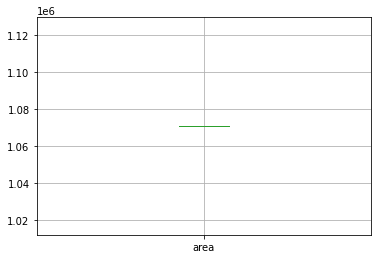

In [21]:
gt_label_df.boxplot(['area'])

(<AxesSubplot:>, 121.66380180401188)

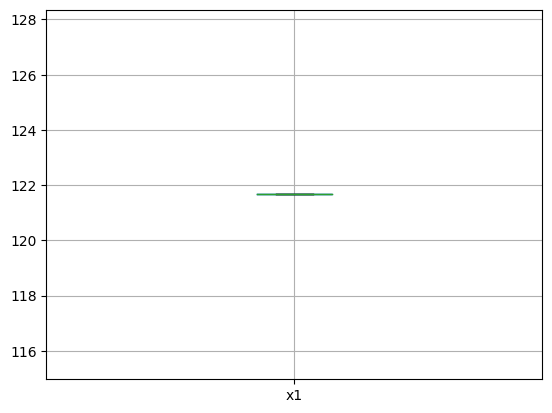

In [22]:
gt_label_df.boxplot(['x1']), gt_label_df['x1'].min()

(<AxesSubplot:>, 1241.663801804012)

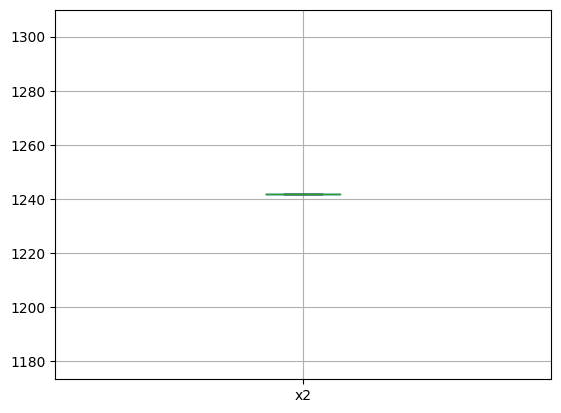

In [23]:
gt_label_df.boxplot(['x2']), gt_label_df['x2'].max()

(<AxesSubplot:>, 113.94260719352587)

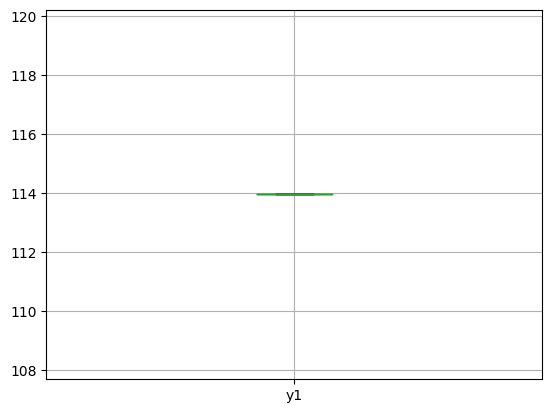

In [24]:
gt_label_df.boxplot(['y1']), gt_label_df['y1'].min()

(<AxesSubplot:>, 1070.0)

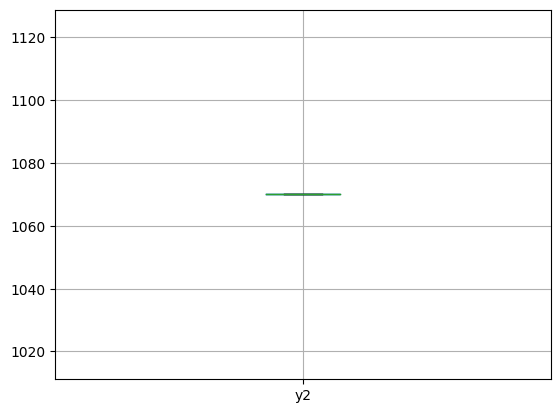

In [25]:
gt_label_df.boxplot(['y2']), gt_label_df['y2'].max()

In [26]:
gt_label_df.min()

patient ID                OC01_R_10s_lowfps
img_no                           img000.png
finger x                         527.435088
finger y                         643.753157
thumb x                          568.125216
thumb y                          694.943964
wristlow x                       826.704422
wristlow y                       924.646304
wristhigh x                      909.397265
wristhigh y                       822.26469
knuckle1 x                       795.202387
knuckle1 y                        652.94125
knuckle2 x                       648.192889
knuckle2 y                       637.190233
class                                     0
x1                               121.663802
y1                               113.942607
x2                              1241.663802
y2                                   1070.0
filename       OC01_R_10s_lowfps_img000.png
area                         1070784.279943
dtype: object

# 3. Dataset Class

In [27]:
#CJM OLD ATTEMPT
class ClassDataset(Dataset):
    def __init__(self, root, df):
        self.root = root
        self.filenames = list(df['filename'])

        #keypoints
        self.finger_x = list(df['finger x'])
        self.finger_y = list(df['finger y'])
        self.thumb_x = list(df['thumb x'])
        self.thumb_y = list(df['thumb y'])
        self.wristlow_x = list(df['wristlow x'])
        self.wristlow_y = list(df['wristlow y'])
        self.wristhigh_x = list(df['wristhigh x'])
        self.wristhigh_y = list(df['wristhigh y'])
        self.knuckle1_x = list(df['knuckle1 x'])
        self.knuckle1_y = list(df['knuckle1 y'])
        self.knuckle2_x = list(df['knuckle2 x'])
        self.knuckle2_y = list(df['knuckle2 y'])

        #bbox coordinates
        self.x1 = list(df['x1'])
        self.x2 = list(df['x2'])
        self.y1 = list(df['y1'])
        self.y2 = list(df['y2'])
        self.area = list(df['area'])


    def __getitem__(self, idx):
        #image file
        img_path = os.path.join(self.root, self.filenames[idx])
        # print(self.filenames[idx])
        img = read_image(img_path)
        img = img.type(torch.float32).div_(255)

        #getting the value from the list for a given idx
        ##keypoints
        finger_x = torch.tensor(float(self.finger_x[idx]), dtype=torch.float32)
        finger_y = torch.tensor(float(self.finger_y[idx]), dtype=torch.float32)
        thumb_x = torch.tensor(float(self.thumb_x[idx]), dtype=torch.float32)
        thumb_y = torch.tensor(float(self.thumb_y[idx]), dtype=torch.float32)
        wristlow_x = torch.tensor(float(self.wristlow_x[idx]), dtype=torch.float32)
        wristlow_y = torch.tensor(float(self.wristlow_y[idx]), dtype=torch.float32)
        wristhigh_x = torch.tensor(float(self.wristhigh_x[idx]), dtype=torch.float32)
        wristhigh_y = torch.tensor(float(self.wristhigh_y[idx]), dtype=torch.float32)
        knuckle1_x = torch.tensor(float(self.knuckle1_x[idx]), dtype=torch.float32)
        knuckle1_y = torch.tensor(float(self.knuckle1_y[idx]), dtype=torch.float32)
        knuckle2_x = torch.tensor(float(self.knuckle2_x[idx]), dtype=torch.float32)
        knuckle2_y = torch.tensor(float(self.knuckle2_y[idx]), dtype=torch.float32)
        ## bbox coordinates
        x1 = torch.tensor(float(self.x1[idx]), dtype=torch.float32)
        x2 = torch.tensor(float(self.x2[idx]), dtype=torch.float32)
        y1 = torch.tensor(float(self.y1[idx]), dtype=torch.float32)
        y2 = torch.tensor(float(self.y2[idx]), dtype=torch.float32)
        area = torch.tensor(float(self.area[idx]), dtype=torch.float32)
        #ensuring that the bounded box coordinates are correct way round
        x0_new = min(x1, x2)
        x1_new = max(x1, x2)
        y0_new = min(y1, y2)
        y1_new = max(y1, y2)

        #getting keypoints into tensors for 3D tensor 
        fingers = torch.tensor([finger_x, finger_y, 1.0])
        thumbs = torch.tensor([thumb_x, thumb_y, 1.0])
        wristlows = torch.tensor([wristlow_x, wristlow_y, 1.0])
        wristhighs = torch.tensor([wristhigh_x, wristhigh_y, 1.0])
        knuckle1s = torch.tensor([knuckle1_x, knuckle1_y, 1.0])
        knuckle2s = torch.tensor([knuckle2_x, knuckle2_y, 1.0])

        #target prep
        boxes = torch.tensor((x0_new,y0_new,x1_new,y1_new)).reshape(4)
        labels = torch.tensor(1, dtype=torch.int64) #0=background, 1=hand
        image_id = torch.tensor(idx,dtype=torch.int64)
        area = torch.tensor(area.clone(),dtype=torch.int64)
        iscrowd = torch.tensor(0, dtype=torch.int64)
        keypoints = torch.stack((fingers, thumbs, wristlows, wristhighs, knuckle1s, knuckle2s))

        #creating target dict
        target = {
            "boxes" : boxes,
            "labels" : labels,
            "image_id" : image_id,
            "area" : area,
            "iscrowd" : iscrowd,
            "keypoints" : keypoints
        }
        
        # img = tuple((img, None))
        # target = tuple((target, None))

        return img, target

    def __len__(self):
        return len(self.filenames)

In [29]:
#template from example


# class ClassDataset(Dataset):
#     def __init__(self, root, transform=None, demo=False):                
#         self.root = root
#         self.transform = transform
#         self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
#         self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
#         self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))
    
#     def __getitem__(self, idx):
#         img_path = os.path.join(self.root, "images", self.imgs_files[idx])
#         annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

#         img_original = cv2.imread(img_path)
#         img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
#         with open(annotations_path) as f:
#             data = json.load(f)
#             bboxes_original = data['bboxes']
#             keypoints_original = data['keypoints']
            
#             # All objects are glue tubes
#             bboxes_labels_original = ['Glue tube' for _ in bboxes_original]            

#         if self.transform:   
#             # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
#             # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
#             # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
#             # Then we need to convert it to the following list:
#             # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
#             keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]
            
#             # Apply augmentations
#             transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
#             img = transformed['image']
#             bboxes = transformed['bboxes']
            
#             # Unflattening list transformed['keypoints']
#             # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
#             # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
#             # Then we need to convert it to the following list:
#             # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
#             keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,2,2)).tolist()

#             # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
#             keypoints = []
#             for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
#                 obj_keypoints = []
#                 for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
#                     # kp - coordinates of keypoint
#                     # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
#                     obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
#                 keypoints.append(obj_keypoints)
        
#         else:
#             img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
#         # Convert everything into a torch tensor        
#         bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
#         target = {}
#         target["boxes"] = bboxes
#         target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are glue tubes
#         target["image_id"] = torch.tensor([idx])
#         target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
#         target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
#         target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)        
#         img = F.to_tensor(img)
        
#         bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
#         target_original = {}
#         target_original["boxes"] = bboxes_original
#         target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are glue tubes
#         target_original["image_id"] = torch.tensor([idx])
#         target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
#         target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
#         target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
#         img_original = F.to_tensor(img_original)

#         if self.demo:
#             return img, target, img_original, target_original
#         else:
#             return img, target
    
#     def __len__(self):
#         return len(self.imgs_files)

# 4. Visualizing a random item from the dataset

In [33]:
# # IMAGE_DIR = ".Park/fullname/fullname"
# IMAGE_DIR = "/home/advai-admin-root/Parkinsons_data/"
# dataset = ClassDataset(IMAGE_DIR, df = gt_label_df)
# train_size = int(0.9 * len(dataset))
# test_size = len(dataset) - train_size

# train_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, test_size])
# data_loader_train = DataLoader(train_ds, batch_size=1, shuffle=True)
# data_loader_test = DataLoader(test_ds, batch_size=1, shuffle=False)

# iterator = iter(data_loader_train)
# batch = next(iterator)
# # img = tuple((img, ))
# # targets = tuple((targets, ))

In [34]:
for k,v in batch[1].items():
    try:
        print(k)
        print(batch[1][k].shape)
        print(batch[1][k].dtype)
        print("\n")
    except:
        continue

NameError: name 'batch' is not defined

## 4.1 CJM Explore Dataloader

In [34]:
# batch[0][0].shape

torch.Size([3, 1080, 1920])

In [35]:
# batch[1]['iscrowd'].shape

torch.Size([1])

In [50]:
keypoints_classes_ids2names = {0: 'Finger', 1: 'Thumb', 2: "Wrist_low", 3: "Wrist_high", 4 : "Knuckle 1", 5 : "Knuckle 2"}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        print(bbox[0])
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
        
# image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
# bboxes = batch[1]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

# keypoints = []
# for kps in batch[1]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
#     keypoints.append([kp[:2] for kp in kps])


# visualize(image, bboxes, keypoints)

In [51]:
# batch[1]

In [52]:
# batch[1]

# 5. Training

In [53]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, hand is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [54]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# print(device)


# model = get_model(num_keypoints = 6)
# model.to(device)


# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(params, lr=2e-2)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
# # step_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 1, factor = 0.1)

# num_epochs = 5

# for epoch in range(num_epochs):
#     train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
#     lr_scheduler.step()
#     evaluate(model, data_loader_test, device)
#     filename = "/home/advai-admin-root/Parkinsons-kprcnn/Parkinsons-kprcnn/models/epoch_" + str(epoch) + '_keypointsrcnn_weights.pth'
#     torch.save(model.state_dict(), filename)

In [55]:
# iterator = iter(data_loader_test)
# batch = next(iterator)

In [56]:
# img, targets = batch

In [57]:
# targets['image_id']

# DEBUG WITH ONE IMAGE

In [58]:
one_df = gt_label_df[:1]
one_dataset = ClassDataset(IMAGE_DIR, df=one_df)
one_data_loader = DataLoader(one_dataset, batch_size=1, shuffle=True)
iterator = iter(one_data_loader)
batch = next(iterator)

/tmp/ipykernel_14976/2708608013.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  area = torch.tensor(area.clone(),dtype=torch.int64)


121


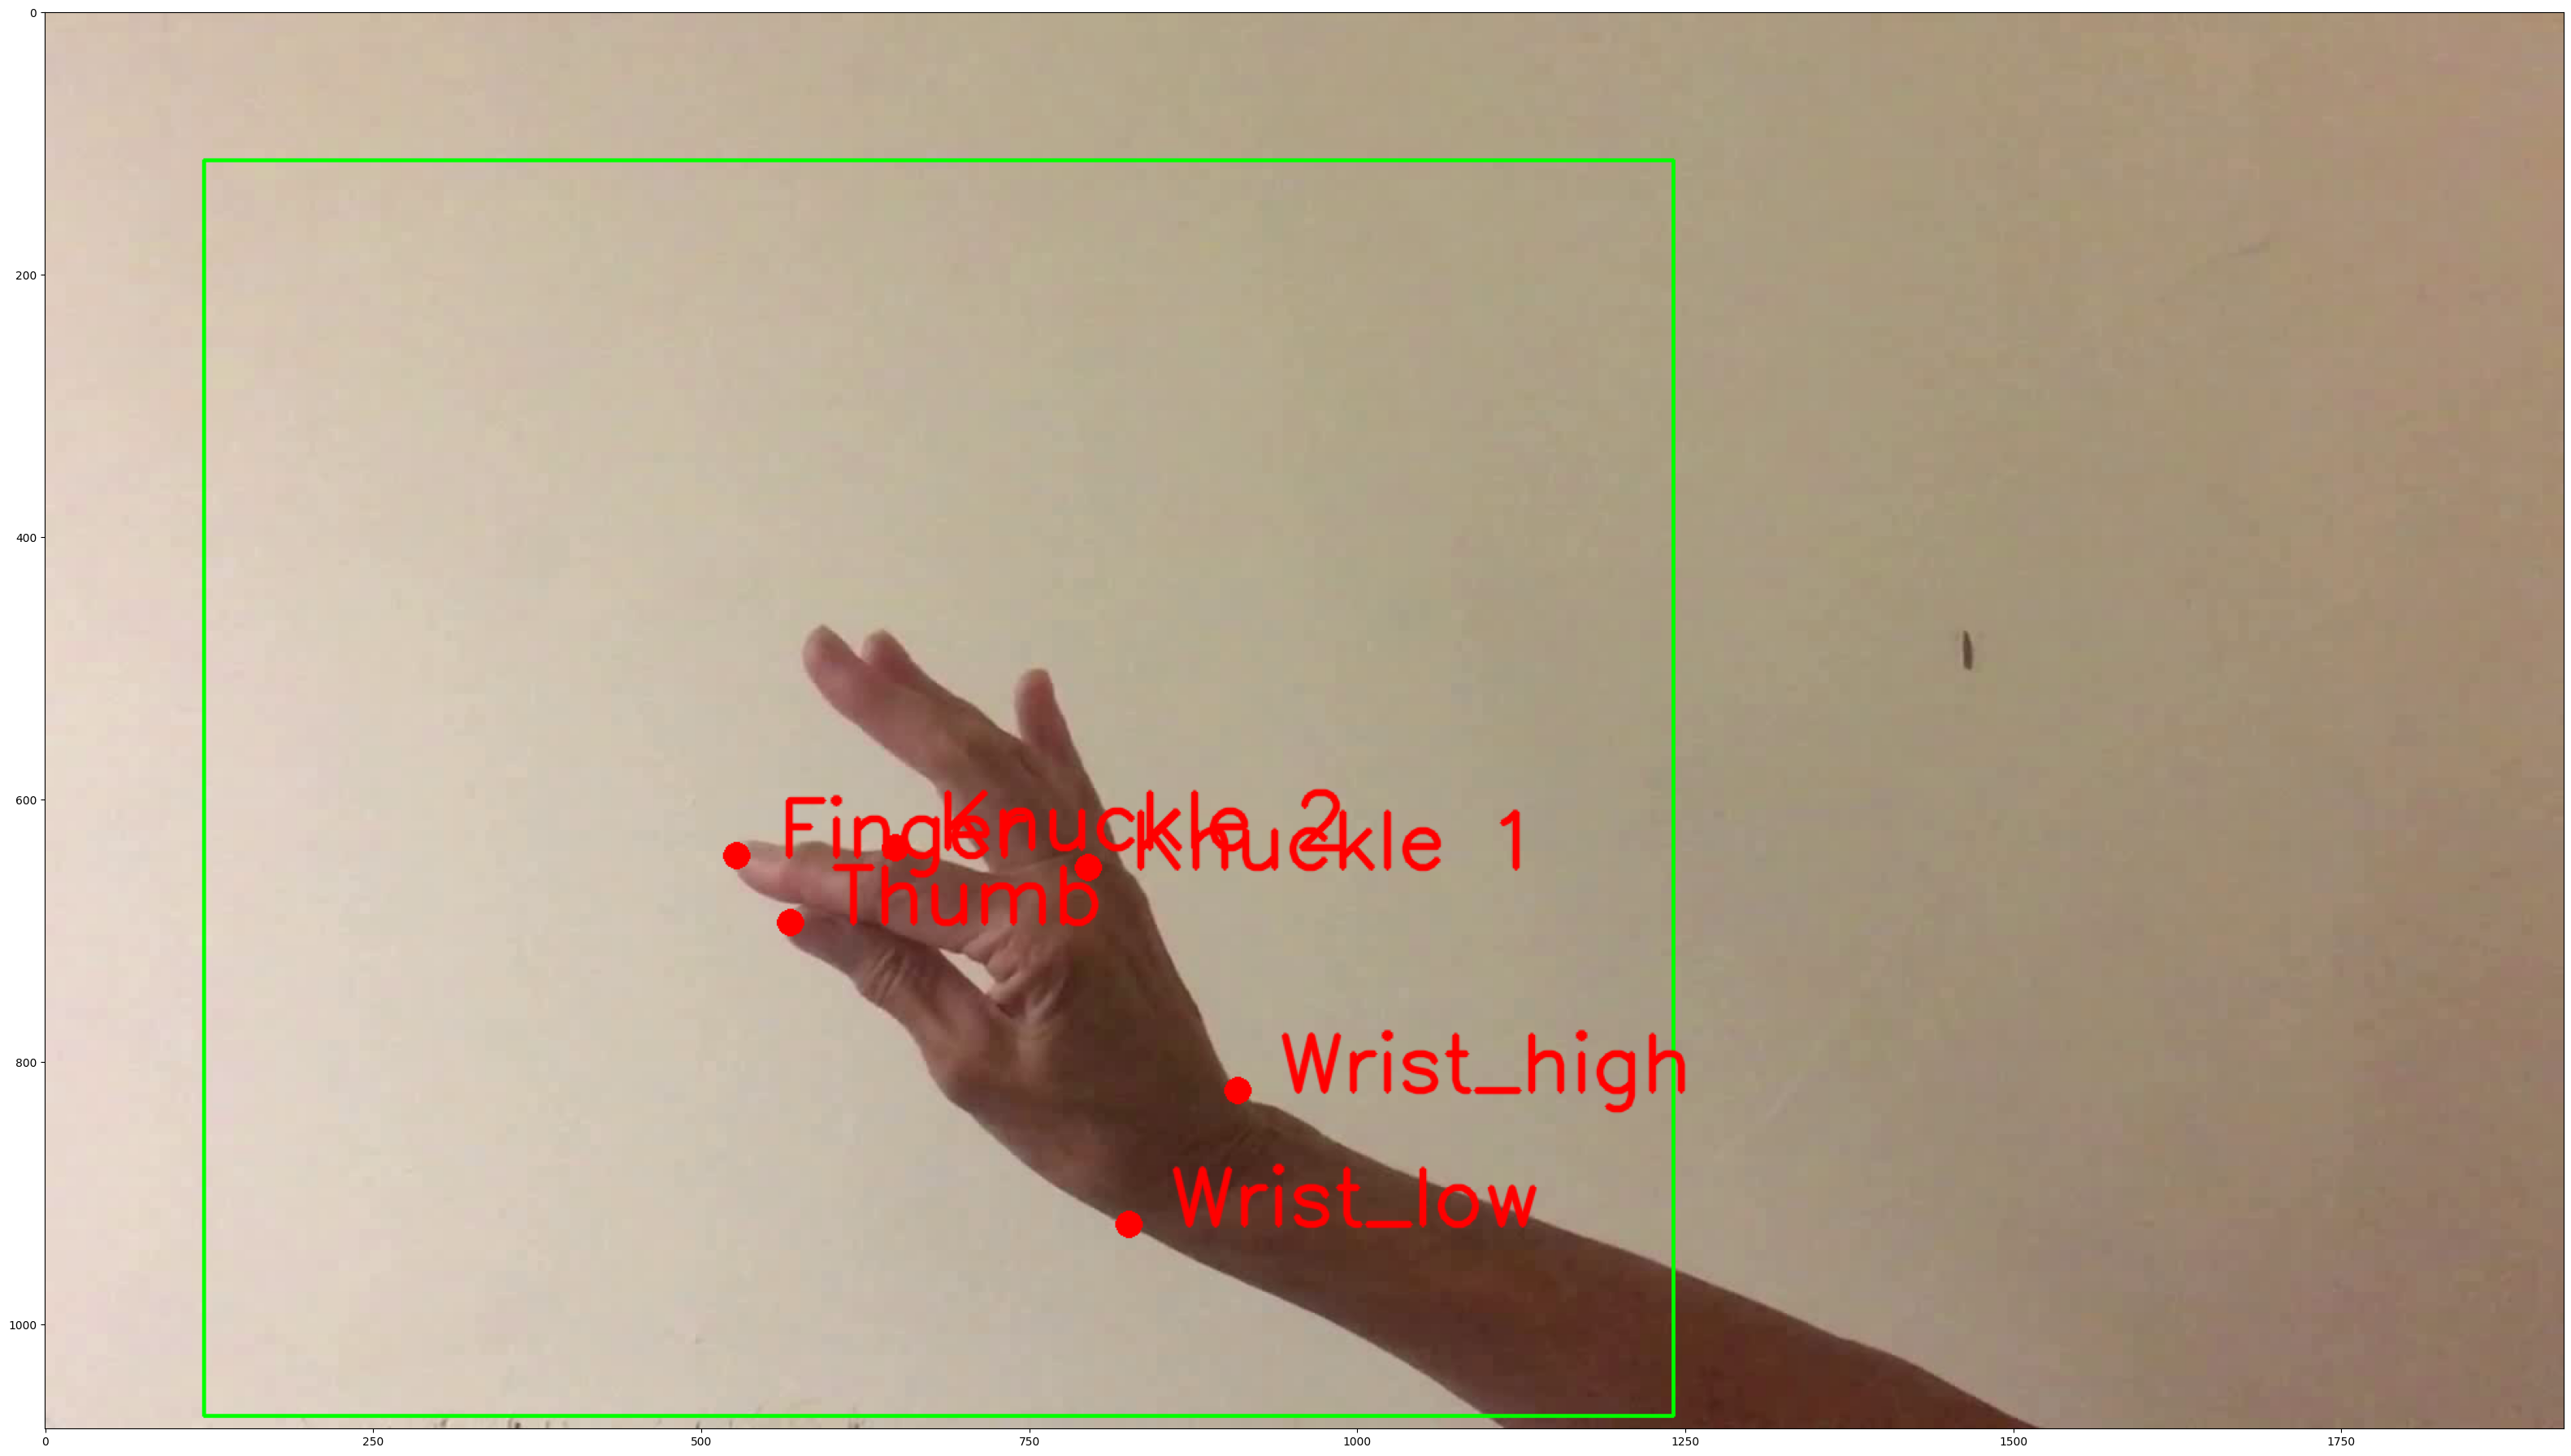

In [59]:
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])


visualize(image, bboxes, keypoints)

In [60]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)


model = get_model(num_keypoints = 6)
model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=2e-2)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
# step_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 1, factor = 0.1)

num_epochs = 1

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, one_data_loader, device, epoch, print_freq=1000)
    lr_scheduler.step()
    evaluate(model, one_data_loader, device)
    filename = "/home/advai-admin-root/Parkinsons-kprcnn/Parkinsons-kprcnn/models/epoch_" + str(epoch) + '_keypointsrcnn_weights.pth'
    torch.save(model.state_dict(), filename)

cuda


/tmp/ipykernel_14976/2708608013.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  area = torch.tensor(area.clone(),dtype=torch.int64)


Epoch: [0]  [0/1]  eta: 0:00:00  lr: 0.000020  loss: 9.5187 (9.5187)  loss_classifier: 0.7544 (0.7544)  loss_box_reg: 0.0103 (0.0103)  loss_keypoint: 8.0425 (8.0425)  loss_objectness: 0.6919 (0.6919)  loss_rpn_box_reg: 0.0196 (0.0196)  time: 0.7209  data: 0.0394  max mem: 1373
Epoch: [0] Total time: 0:00:00 (0.7227 s / it)
[1]
creating index...
index created!


IndexError: boolean index did not match indexed array along dimension 0; dimension is 6 but corresponding boolean dimension is 1

In [ ]:
assert False

# CJM TO MP:
IGNORE PAST THIS POINT

# 6. Visualizing model predictions

In [ ]:
iterator = iter(data_loader_test)
images, targets = next(iterator)
images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

print("Predictions: \n", output)

Here we see a lot of predicted objects. We will choose only those with high confidence score (for example, > 0.7). Then we will apply Non-Maximum Surpression (NMS) procedure to select the most appropriate bounding boxes among remaining ones.

Essentially, NMS leaves the boxes with the highest confidence score (the best candidates) and removes other boxes, which partially overlap the best candidates. To define the degree of this overlapping, we will set the threshold for Intersection over Union (IoU) equal 0.3.

In [ ]:
image = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

# Below, in output[0]['keypoints'][high_scores_idxs][post_nms_idxs] and output[0]['boxes'][high_scores_idxs][post_nms_idxs]
# Firstly, we choose only those objects, which have score above predefined threshold. This is done with choosing elements with [high_scores_idxs] indexes
# Secondly, we choose only those objects, which are left after NMS is applied. This is done with choosing elements with [post_nms_idxs] indexes

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])

bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))
    
visualize(image, bboxes, keypoints)

Predictions look good: bounding boxes are almost precise, keypoints are in the right places. It means the model is trained quite well.

In the same manner you can train Keypoint RCNN using another dataset, choosing any number of keypoints.